In [ ]:
! git clone https://github.com/UCMerced-ML/LC-model-compression

Cloning into 'LC-model-compression'...
remote: Enumerating objects: 166, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 166 (delta 63), reused 142 (delta 42), pack-reused 0
Receiving objects: 100% (166/166), 3.19 MiB | 8.28 MiB/s, done.
Resolving deltas: 100% (63/63), done.


In [ ]:
! pip3 install -e ./LC-model-compression
! pip3 install utils

Obtaining file:///content/LC-model-compression
  Running setup.py develop for lc


## IMPORTANT!
At this point you need to restart the runtime by doing "Runtime => Restart Runtime"

In [ ]:
import lc
from lc.torch import ParameterTorch as Param, AsVector, AsIs
from lc.compression_types import ConstraintL0Pruning, LowRank, RankSelection, AdaptiveQuantization
from lc.models.torch.utils import LambdaLayer 
from lc.models.torch import lenet300_classic, lenet300_modern_drop, lenet300_modern
from lc.models.torch.lenet5 import _weights_init

# from utils import compute_acc_loss

import utils
import os
import datetime
import torch
import scipy.io
import tensorflow as tf
import torch.nn.init as init
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from collections import OrderedDict
from torch.nn.init import xavier_uniform_
from scipy.io import loadmat
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import numpy as np

import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets
torch.set_num_threads(4)

In [ ]:
def compute_acc_loss(forward_func, data_loader):
    correct_cnt, ave_loss = 0, 0
    for batch_idx, (x, target) in enumerate(data_loader):
        with torch.no_grad():
            target = target.cuda()
            score, loss = forward_func(x.cuda(), target)
            _, pred_label = torch.max(score.data, 1)
            correct_cnt += (pred_label == target.data).sum().item()
            ave_loss += loss.data.item() * len(x)
    accuracy = correct_cnt * 1.0 / len(data_loader.dataset)
    ave_loss /= len(data_loader.dataset)
    return accuracy, ave_loss

## Data
We use the MNIST dataset for this demo. The dataset containssubtracted 28x28 grayscale images with digits from 0 to 9. The images are normalized to have grayscale value 0 to 1 and then mean is subtracted.

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



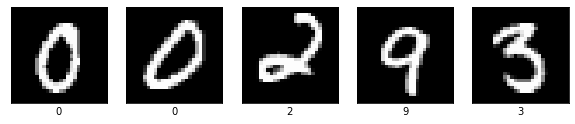

In [ ]:
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [10, 5]
def show_MNIST_images():
    train_data_th = datasets.MNIST(root='./datasets', download=True, train=True)
    data_train = np.array(train_data_th.data[:])
    targets = np.array(train_data_th.targets)
    images_to_show = 5
    random_indexes = np.random.randint(data_train.shape[0], size=images_to_show)
    for i,ind in enumerate(random_indexes):
        plt.subplot(1,images_to_show,i+1)
        plt.imshow(data_train[ind], cmap='gray')
        plt.xlabel(targets[ind])
        plt.xticks([])
        plt.yticks([])
show_MNIST_images()

In [ ]:
def data_loader(batch_size=1024, n_workers=4):
    train_data_th = datasets.MNIST(root='./datasets', download=True, train=True)
    test_data_th = datasets.MNIST(root='./datasets', download=True, train=False)

    data_train = np.array(train_data_th.data[:]).reshape([-1, 28 * 28]).astype(np.float32)
    data_test = np.array(test_data_th.data[:]).reshape([-1, 28 * 28]).astype(np.float32)
    data_train = (data_train / 255)
    dtrain_mean = data_train.mean(axis=0)
    data_train -= dtrain_mean
    data_test = (data_test / 255).astype(np.float32)
    data_test -= dtrain_mean

    train_data = TensorDataset(torch.from_numpy(data_train), train_data_th.targets)
    test_data = TensorDataset(torch.from_numpy(data_test), test_data_th.targets)

    train_loader = DataLoader(train_data, num_workers=n_workers, batch_size=batch_size, shuffle=True,)
    test_loader = DataLoader(test_data, num_workers=n_workers, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

##Reference Network
We use cuda capable GPU for our experiments. The network has 3 fully-connected layers with dimensions 784x300, 300x100, and 100x10, and the total of 266200 parameters (which includes biases). The network was trained to have a test error of 1.79%, which is pretty decent result but not as low as you can get with convolutional neural networks.


In [ ]:
device = torch.device('cuda') 

In [ ]:
class LeNet5_mnist_subset(nn.Module):
    """
    Pulled from https://github.com/UCMerced-ML/LC-model-compression/blob/master/lc/models/torch/lenet5.py
    Changed 'layers' so that output is at 5 (for the subset)
    """
    def __init__(self, dropout, nonlinearity):
        super(LeNet5_mnist_subset, self).__init__()
        self.special = True
        filters = [(20, 5), (50, 5)]
        layers = [(800, 500), (500, 5)]

        cfg = []
        cfg.append(['init_reshape', LambdaLayer(lambda x: x.view(x.size(0), 1,28,28))])
        for i, f in enumerate(filters):
            prev = 1 if i==0 else filters[i-1][0]
            cfg.append(('compressible_' + str(i), nn.Conv2d(prev, f[0], f[1])))
            cfg.append(('nonlineairy_'+str(i), nonlinearity()))
            cfg.append(('maxpool_'+str(i), nn.MaxPool2d(kernel_size=(2,2), stride=2)))


        cfg.append(['reshape', LambdaLayer(lambda x: x.view(x.size(0),-1))])
        for i, l in enumerate(layers):
            cfg.append(('compressible_' + str(i+len(filters)), nn.Linear(*l)))
            if i != len(layers)-1:
                # only non terminal layers have nonlinearity and (possible) dropouts
                cfg.append(('nonlinearity_' + str(i+len(filters)), nonlinearity()))
                if dropout:
                    cfg.append(('drop_'+str(i+len(filters)), nn.Dropout()))

        print(cfg)

        self.output = nn.Sequential(OrderedDict(cfg))
        self.loss = nn.CrossEntropyLoss()
        self.apply(_weights_init)

    def forward(self, input):
        return self.output(input)

In [ ]:
def train_test_acc_eval_f(net):
    train_loader, test_loader = data_loader()
    def forward_func(x, target):
        y = net(x)
        return y, net.loss(y, target)
    acc_train, loss_train = compute_acc_loss(forward_func, train_loader)
    acc_test, loss_test = compute_acc_loss(forward_func, test_loader)

    print(f"Train err: {100-acc_train*100:.2f}%, train loss: {loss_train}")
    print(f"TEST ERR: {100-acc_test*100:.2f}%, test loss: {loss_test}")
    
def load_reference_lenet300():
    net = LeNet5_mnist_subset(dropout=False, nonlinearity=lambda: nn.ReLU(True)).to(device)
    # net = lenet300_modern().to(device)
    # state_dict = torch.load('lenet300_modern_drop_wd.th')
    # state_dict = torch.utils.model_zoo.load_url('https://ucmerced.box.com/shared/static/766axnc8qq429hiqqyqqo07ek46oqoxq.th')
    # net.load_state_dict(state_dict)
    return net

In [ ]:
evals = load_reference_lenet300().eval()

[['init_reshape', LambdaLayer()], ('compressible_0', Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))), ('nonlineairy_0', ReLU(inplace=True)), ('maxpool_0', MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)), ('compressible_1', Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))), ('nonlineairy_1', ReLU(inplace=True)), ('maxpool_1', MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)), ['reshape', LambdaLayer()], ('compressible_2', Linear(in_features=800, out_features=500, bias=True)), ('nonlinearity_2', ReLU(inplace=True)), ('compressible_3', Linear(in_features=500, out_features=5, bias=True))]
LambdaLayer
Conv2d
ReLU
MaxPool2d
Conv2d
ReLU
MaxPool2d
LambdaLayer
Linear
ReLU
Linear
Sequential
CrossEntropyLoss
LeNet5_mnist_subset


In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
train_test_acc_eval_f(load_reference_lenet300().eval())

[['init_reshape', LambdaLayer()], ('compressible_0', Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))), ('nonlineairy_0', ReLU(inplace=True)), ('maxpool_0', MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)), ('compressible_1', Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))), ('nonlineairy_1', ReLU(inplace=True)), ('maxpool_1', MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)), ['reshape', LambdaLayer()], ('compressible_2', Linear(in_features=800, out_features=500, bias=True)), ('nonlinearity_2', ReLU(inplace=True)), ('compressible_3', Linear(in_features=500, out_features=5, bias=True))]
LambdaLayer
Conv2d
ReLU
MaxPool2d
Conv2d
ReLU
MaxPool2d
LambdaLayer
Linear
ReLU
Linear
Sequential
CrossEntropyLoss
LeNet5_mnist_subset


RuntimeError: ignored

## Compression using the LC toolkit
### Step 1: L step
We will use same L step with same hyperparamters for all our compression examples

In [ ]:
def my_l_step(model, lc_penalty, step):
    train_loader, test_loader = data_loader()
    params = list(filter(lambda p: p.requires_grad, model.parameters()))
    lr = 0.7*(0.98**step)
    optimizer = optim.SGD(params, lr=lr, momentum=0.9, nesterov=True)
    print(f'L-step #{step} with lr: {lr:.5f}')
    epochs_per_step_ = 7
    if step == 0:
        epochs_per_step_ = epochs_per_step_ * 2
    for epoch in range(epochs_per_step_):
        avg_loss = []
        for x, target in train_loader:
            optimizer.zero_grad()
            x = x.to(device)
            target = target.to(dtype=torch.long, device=device)
            out = model(x)
            loss = model.loss(out, target) + lc_penalty()
            avg_loss.append(loss.item())
            loss.backward()
            optimizer.step()

        print(f"\tepoch #{epoch} is finished.")
        print(f"\t  avg. train loss: {np.mean(avg_loss):.6f}")

### Step 2: Schedule of mu values

In [ ]:
mu_s = [9e-5 * (1.1 ** n) for n in range(20)]
# 20 L-C steps in total
# total training epochs is 7 x 20 = 140

### Compression time! Pruning
Let us prune all but 5% of the weights in the network (5% = 13310 weights)

In [ ]:
net = load_reference_lenet300()

layers = [lambda x=x: getattr(x, 'weight') for x in net.modules() if isinstance(x, nn.Linear)]
compression_tasks = {
    Param(layers, device): (AsVector, ConstraintL0Pruning(kappa=13310), 'pruning')
}

lc_alg = lc.Algorithm(
    model=net,                            # model to compress
    compression_tasks=compression_tasks,  # specifications of compression
    l_step_optimization=my_l_step,        # implementation of L-step
    mu_schedule=mu_s,                     # schedule of mu values
    evaluation_func=train_test_acc_eval_f # evaluation function
)
lc_alg.run()                              # entry point to the LC algorithm

In [ ]:
lc_alg.count_params()

In [ ]:
compressed_model_bits = lc_alg.count_param_bits() + (300+100+10)*32
uncompressed_model_bits = (784*300+300*100+100*10 + 300 + 100 + 10)*32
compression_ratio = uncompressed_model_bits/compressed_model_bits
print(compression_ratio)

Note that we were pruning 95% of the weights. Naively, you would assume 20x compression ratio (100%/5%), however, this is not the case. Firstly, there are some uncompressed parts (in this case biases), and, secondly, storing a compressed model requires additional metadata (in this case positions of non-zero elements). Therefore we get only 16x compression ratio (vs naively expected 20x). 

To prevent manual computation of compression ratio, let us create a function below. Note, this function is model specific.

In [ ]:
def compute_compression_ratio(lc_alg):
    compressed_model_bits = lc_alg.count_param_bits() + (300+100+10)*32
    uncompressed_model_bits = (784*300+300*100+100*10 + 300 + 100 + 10)*32
    compression_ratio = uncompressed_model_bits/compressed_model_bits
    return compression_ratio

### Quantization
Now let us quantize each layer with its own codebook

In [ ]:
net = load_reference_lenet300()
layers = [lambda x=x: getattr(x, 'weight') for x in net.modules() if isinstance(x, nn.Linear)]

compression_tasks = {
    Param(layers[0], device): (AsVector, AdaptiveQuantization(k=2), 'layer0_quant'),
    Param(layers[1], device): (AsVector, AdaptiveQuantization(k=2), 'layer1_quant'),
    Param(layers[2], device): (AsVector, AdaptiveQuantization(k=2), 'layer2_quant')
}

lc_alg = lc.Algorithm(
    model=net,                            # model to compress
    compression_tasks=compression_tasks,  # specifications of compression
    l_step_optimization=my_l_step,        # implementation of L-step
    mu_schedule=mu_s,                     # schedule of mu values
    evaluation_func=train_test_acc_eval_f # evaluation function
)
lc_alg.run()  
print('Compressed_params:', lc_alg.count_params())
print('Compression_ratio:', compute_compression_ratio(lc_alg))

### Mixing pruning, low rank, and quantization

In [ ]:
net = load_reference_lenet300()
layers = [lambda x=x: getattr(x, 'weight') for x in net.modules() if isinstance(x, nn.Linear)]

compression_tasks = {
    Param(layers[0], device): (AsVector, ConstraintL0Pruning(kappa=5000), 'pruning'),
    Param(layers[1], device): (AsIs, LowRank(target_rank=9, conv_scheme=None), 'low-rank'),
    Param(layers[2], device): (AsVector, AdaptiveQuantization(k=2), 'quant')
}

lc_alg = lc.Algorithm(
    model=net,                            # model to compress
    compression_tasks=compression_tasks,  # specifications of compression
    l_step_optimization=my_l_step,        # implementation of L-step
    mu_schedule=mu_s,                     # schedule of mu values
    evaluation_func=train_test_acc_eval_f # evaluation function
)
lc_alg.run()
print('Compressed_params:', lc_alg.count_params())
print('Compression_ratio:', compute_compression_ratio(lc_alg))

### Additive combination of Quantization and Pruning

In [ ]:
net = load_reference_lenet300()
layers = [lambda x=x: getattr(x, 'weight') for x in net.modules() if isinstance(x, nn.Linear)]

compression_tasks = {
    Param(layers, device): [
        (AsVector, ConstraintL0Pruning(kappa=2662), 'pruning'),
        (AsVector, AdaptiveQuantization(k=2), 'quant')
    ]
}

lc_alg = lc.Algorithm(
    model=net,                            # model to compress
    compression_tasks=compression_tasks,  # specifications of compression
    l_step_optimization=my_l_step,        # implementation of L-step
    mu_schedule=mu_s,                     # schedule of mu values
    evaluation_func=train_test_acc_eval_f # evaluation function
)
lc_alg.run()
print('Compressed_params:', lc_alg.count_params())
print('Compression_ratio:', compute_compression_ratio(lc_alg))

### Low-rank compression with automatic rank selection

In [ ]:
net = load_reference_lenet300()
layers = [lambda x=x: getattr(x, 'weight') for x in net.modules() if isinstance(x, nn.Linear)]
alpha=1e-9
compression_tasks = {
    Param(layers[0], device): (AsIs, RankSelection(conv_scheme='scheme_1', alpha=alpha, criterion='storage', module=layers[0], normalize=True), "layer1_lr"),
    Param(layers[1], device): (AsIs, RankSelection(conv_scheme='scheme_1', alpha=alpha, criterion='storage', module=layers[1], normalize=True), "layer2_lr"),
    Param(layers[2], device): (AsIs, RankSelection(conv_scheme='scheme_1', alpha=alpha, criterion='storage', module=layers[2], normalize=True), "layer3_lr")
}

lc_alg = lc.Algorithm(
    model=net,                            # model to compress
    compression_tasks=compression_tasks,  # specifications of compression
    l_step_optimization=my_l_step,        # implementation of L-step
    mu_schedule=mu_s,                     # schedule of mu values
    evaluation_func=train_test_acc_eval_f # evaluation function
)
lc_alg.run()
print('Compressed_params:', lc_alg.count_params())
print('Compression_ratio:', compute_compression_ratio(lc_alg))

### ScaledBinaryQuantization

In [ ]:
from lc.compression_types import ScaledBinaryQuantization
net = load_reference_lenet300()
layers = [lambda x=x: getattr(x, 'weight') for x in net.modules() if isinstance(x, nn.Linear)]

compression_tasks = {
    Param(layers[0], device): (AsVector, ScaledBinaryQuantization(), 'layer0_quant'),
    Param(layers[1], device): (AsVector, ScaledBinaryQuantization(), 'layer1_quant'),
    Param(layers[2], device): (AsVector, ScaledBinaryQuantization(), 'layer2_quant')
}

lc_alg = lc.Algorithm(
    model=net,                            # model to compress
    compression_tasks=compression_tasks,  # specifications of compression
    l_step_optimization=my_l_step,        # implementation of L-step
    mu_schedule=mu_s,                     # schedule of mu values
    evaluation_func=train_test_acc_eval_f # evaluation function
)
lc_alg.run()
print('Compressed_params:', lc_alg.count_params())
print('Compression_ratio:', compute_compression_ratio(lc_alg))

### ScaledTernaryQuantization

In [ ]:
from lc.compression_types import ScaledTernaryQuantization
net = load_reference_lenet300()
layers = [lambda x=x: getattr(x, 'weight') for x in net.modules() if isinstance(x, nn.Linear)]

compression_tasks = {
    Param(layers[0], device): (AsVector, ScaledTernaryQuantization(), 'layer0_quant'),
    Param(layers[1], device): (AsVector, ScaledTernaryQuantization(), 'layer1_quant'),
    Param(layers[2], device): (AsVector, ScaledTernaryQuantization(), 'layer2_quant')
}

lc_alg = lc.Algorithm(
    model=net,                            # model to compress
    compression_tasks=compression_tasks,  # specifications of compression
    l_step_optimization=my_l_step,        # implementation of L-step
    mu_schedule=mu_s,                     # schedule of mu values
    evaluation_func=train_test_acc_eval_f # evaluation function
)
lc_alg.run() 
print('Compressed_params:', lc_alg.count_params())
print('Compression_ratio:', compute_compression_ratio(lc_alg))